<a href="https://colab.research.google.com/github/nikhil9302/supreme-CLIP/blob/development/text%20image%20search/text_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Image Search

##Download the dataset JSON 

In [ ]:
!gdown --id 1EvRZNlS0d41ngcSv1wxLSJCdZV27wzf2

Downloading...
From: https://drive.google.com/uc?id=1EvRZNlS0d41ngcSv1wxLSJCdZV27wzf2
To: /content/data.json
100% 455M/455M [00:04<00:00, 103MB/s] 


##Install CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c5pzrfdj
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-c5pzrfdj
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=bae431369a5121954e363f0b91b924d6583debd089806cad4a9ac9a201dfdcbc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehx98rwp/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=6aad1927f0e2ccbf424c409f68c66ee60427a8bc6daddd2151c051b370211430
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


##Preprocess Data

In [ ]:
import json 
import torch

with open('data.json', 'r') as f:
    data = json.loads(f.read())

In [ ]:
def preprocess_data(data):
    image_embd = [] #to store all CLIP embeddings
    for i in data.keys():
        data[i]['image_features'] = torch.tensor(list(map(float,data[i]['image_features'][0])), dtype = torch.float).unsqueeze(0)
        image_embd.append(data[i]['image_features'])
    image_embd = torch.cat(image_embd)
    image_embd /= image_embd.norm(dim = -1, keepdim=True) #normalize
    keys = list(data.keys()) #collect keys
    print(f"There are {len(keys)} no. of image embeddings of size {image_embd.shape}")
    return data, keys, image_embd # preprocessed data, list of keys and image embeddings tensor

In [ ]:
data, keys, image_embd = preprocess_data(data)

There are 24990 no. of image embeddings of size torch.Size([24990, 512])


##Model initialization

In [ ]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
image_embd = image_embd.to(device)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 128MiB/s]


##User input text

In [ ]:
#@title Query Text

text = "cat" #@param {type: "string"}
print(f"You would like to search for images of \"{text}\"")

You would like to search for images of "cat"


##Define Similarity Function

In [ ]:
import numpy as np
from PIL import Image
def get_sim(text):
    with torch.inference_mode():
        text = clip.tokenize([text])
        text = text.to(device)
        text_features = model.encode_text(text).float()
        text_features /= text_features.norm(dim=-1, keepdim=True) 
       

        logit_scale = 100 
        logits= (logit_scale * image_embd @ text_features.t()).squeeze()
        logits = logits.cpu().numpy()
        best_photo_idx = np.argsort(logits)[::-1]
        best_photos = [(logits[i],i) for i in best_photo_idx]
    return best_photos #return Best matched photos

In [ ]:
best_photos = get_sim(text)

##Display the images

In [ ]:
#@title String fields

num = 16 #@param {type:"integer"}

print(f"You would like to see {num} images")


You would like to see 16 images


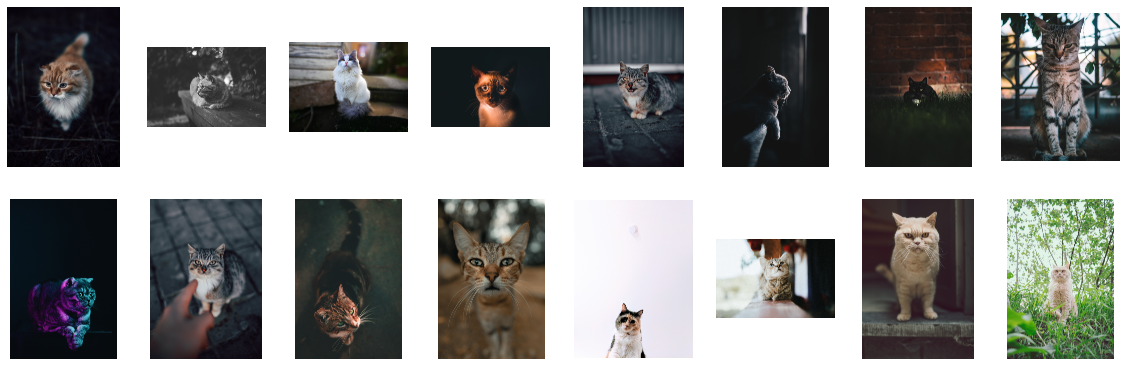

In [ ]:
import urllib
import matplotlib.pyplot as plt


ncol = 8
nrow = num // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(num):
    url = data[keys[best_photos[i][1]]]['image_url']
    plt.subplot(nrow, ncol, i+1)
    image = Image.open(urllib.request.urlopen(url))
    plt.imshow(image)
    plt.axis('off')